In [24]:
import matplotlib.pyplot as plt
import torch
from utils.registry import registry, setup_imports
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import os
from scipy import stats

In [25]:
from trainer_heanet_mtl import validate_model, evaluate, load_mp_data
from trainer_heanet_mtl_HEA import load_hea_data, load_hea_data_single_file
from datasets.Mp_dataset import MpGeometricDataset
from datasets.preprocessing import PoscarToGraph

In [47]:

device = torch.device(device='cuda' if torch.cuda.is_available() else 'cpu')


def load_model(model_name, hidden_channels=128, n_filters=64, n_interactions=3,
               n_gaussians=50, cutoff=10, num_tasks=2, tower_h1=128,
               tower_h2=64):
    """
    load the trained ML models given the model_name.
    It should be noted that the hyper parameters are assigned according to the specific trained hyper parameters.

    args:
        model_name: str. the name of the trained model.
        For example: './saved_models/ms_type0_300.pt'
    """
    # load the ML model.
    setup_imports()
    device = torch.device(device='cuda' if torch.cuda.is_available() else 'cpu')
    model = registry.get_model('heanet'
                               )(hidden_channels=hidden_channels,
                                 num_filters=n_filters,
                                 num_interactions=n_interactions,
                                 num_gaussians=n_gaussians,
                                 cutoff=cutoff,
                                 readout='add',
                                 dipole=False, mean=None, std=None,
                                 atomref=None, num_tasks=num_tasks,
                                 tower_h1=tower_h1,
                                 tower_h2=tower_h2)
    # load parameters of trained model
    model_state = torch.load(model_name, map_location=device)
    model.load_state_dict(model_state)
    model.to(device)
    return model



In [48]:
class ModelPrediction(object):
    """ Assign the parameters for model and datasets.

    When tasks come from Multi-target learning model, it should be a list including str, such as ['ef', 'eg'].
    At the same time, the transforms should be like ['scaling', 'scaling']
    
    Args:
        model_name (str): The saved model name.
        tasks (List[str], optional): What tasks to predict, which is related to the model.
            (default: ['ef', 'eg'])
        transforms (List[str], optional): The data will be transformed with specific transformation type. For 
            example, the 'scaling', 'log', etc.
        hidden_channels (int, optional): number of hidden channels for the embeddings
            (default: 128)
        n_filters (int, optional): number of filters
            (default: 64)
        n_interactions (int, optional): number of interaction blocks
            (default: 3)
        n_gaussians (int, optional): number of gaussian bases to expand the distances
            (default: 50)
        cutoff (int, optional): the cutoff radius to consider passing messages
            (default: 10)
        load_data_func (str): The dataloader object to load the data from dataset.
            (default: 'mp')
    """
    def __init__(self, model_name, tasks=None, transforms=None,
                 hidden_channels=128, n_filters=64, n_interactions=3,
                 n_gaussians=50, cutoff=10, load_data_func='mp'):
        if tasks is None:
            tasks = ['ef', 'eg']
        self.model_name = model_name
        self.tasks = tasks
        self.transforms = transforms
        self.hidden_channels = hidden_channels
        self.n_filters=n_filters
        self.n_interactions=n_interactions
        self.n_gaussians = n_gaussians
        self.cutoff=cutoff
        if load_data_func=='mp':
            self.train_loader, self.validate_loader, self.test_loader = load_mp_data(task=self.tasks, is_validate=True)
        else:
            self.train_loader, self.validate_loader, self.test_loader = load_hea_data_single_file(split_type=2, is_validate=True)
        self.model = self._load_model()
    
    def _load_model(self):
        model = load_model(self.model_name, hidden_channels=self.hidden_channels,
                   n_filters=self.n_filters, n_interactions=self.n_interactions,
                   n_gaussians=self.n_gaussians, cutoff=self.cutoff)
        return model

    def obtain_predictions_from_mtl(self):
        model=self.model
        out_pred, out_true = validate_model(model, self.test_loader, tasks=self.tasks,
                                            transforms=self.transforms)
        score = evaluate(out_pred, out_true)
        print('mae in the test set is {}'.format(score))
        return out_true, out_pred

    def obtain_predictions_from_stl(self, model_name, task='ef'):
        """
        This function is similar to the test function. It uses the trained model to predict the data.
        So, it needs to initialize the model at first. Then, parameters are loaded into the ML model.
        :param
            model_name: 'str', the ML model name, like  './saved_models_lin_256/k_mp_log_500.pt'.
            task: 'str'. The target predictioin.
        :return:
            y_true: ndarray.
            y_pred: ndarray.
        """
        model = load_model(model_name)
        model.eval()  # freeze the dropout and BN layer
        y_pred = []
        y_true = []
        with torch.no_grad():
            end_time = 0
            # for batch in train_loader:
            for batch in self.test_loader:
                batch.to(device)
                out = model(batch.atomic_numbers.long(), batch.pos, batch=batch)
                # It does not change the variable at default
                # However, we directly compare the log-form data to compare with previous paper.
                if task == 'k' or task == 'g':
                    y_label = transform('log', batch.__getitem__(task), forward=True)
                else:
                    y_label = batch.__getitem__(task)
                y_true.append(y_label)
                # It should scale into the raw range due to the prediction enlarge the original data in case of scaling.
                # However, we directly compare the log-form data to compare with previous paper.
                if task == 'ef' or task == 'eg':
                    out = transform('scaling', out, forward=False)
                y_pred.append(out)

        y_true = torch.cat(y_true, dim=0).detach().cpu().numpy()
        y_pred = torch.cat(y_pred, dim=0).detach().cpu().numpy()

        print(y_true.shape, y_pred.shape)
        print(y_true, y_pred)
        mae_s = mean_absolute_error(y_true, y_pred)
        r2_s = r2_score(y_true, y_pred)
        print(r2_s, mae_s)
        return y_true, y_pred
    
    def convert_data(self, filename):
        """
        the file name of the poscars
        args:
            filename: str. './HEA_Data/Binary_POSCAR_Files/POSCAR_Co3Cr_sqsfcc'
        """
        pg = PoscarToGraph(radius=self.cutoff, max_neigh=200)
        data = pg.to_graph(filename)
        data.to(device=device)
        return data

    def predict(self, poscar):
        """
        Given a structure in 'POSCAR' format, it will predict its properties according to your requirements.
        
        """
        
        model = self.model
        model.eval()
        data = self.convert_data(poscar)
        out = model(data.atomic_numbers.long(), data.pos)
        return out

In [49]:
mp_mtl = ModelPrediction(model_name='./saved_models_mtl/mtl_2_mp_500_best.pt',
                         tasks=['ef' ,'eg'], transforms=['scaling', 'scaling'],
                         hidden_channels=128, n_filters=64, n_interactions=3,
                         n_gaussians=50, cutoff=10
                         )
y_true, y_pred = mp_mtl.obtain_predictions_from_mtl()


loading the processed data from D:\GitProjects\HEA_project\datasets\mp
loading dataset of ef and eg.
loading dataset of ef and eg.
The total data size is 69239.
The training data is set 60000 manually for comparison
the score of task 0 is 0.11146006733179092

the score of task 1 is 0.2451019287109375

mae in the test set is 0.1782809980213642


In [59]:
mp_mtl.model.state_dict()

OrderedDict([('atomic_mass',
              tensor([  1.0000,   1.0080,   4.0026,   6.9400,   9.0122,  10.8100,  12.0110,
                       14.0070,  15.9990,  18.9984,  20.1797,  22.9898,  24.3050,  26.9815,
                       28.0850,  30.9738,  32.0600,  35.4500,  39.9480,  39.0983,  40.0780,
                       44.9559,  47.8670,  50.9415,  51.9961,  54.9380,  55.8450,  58.9332,
                       58.6934,  63.5460,  65.3800,  69.7230,  72.6300,  74.9216,  78.9710,
                       79.9040,  83.7980,  85.4678,  87.6200,  88.9058,  91.2240,  92.9064,
                       95.9500,  97.9072, 101.0700, 102.9055, 106.4200, 107.8682, 112.4140,
                      114.8180, 118.7100, 121.7600, 127.6000, 126.9045, 131.2930, 132.9055,
                      137.3270, 138.9055, 140.1160, 140.9077, 144.2420, 144.9128, 150.3600,
                      151.9640, 157.2500, 158.9254, 162.5000, 164.9303, 167.2590, 168.9342,
                      173.0540, 174.9668, 178.4900,

In [58]:
for i in mp_mtl.model.state_dict():
    print(i)

atomic_mass
tower_layers.0.0.weight
tower_layers.0.0.bias
tower_layers.0.2.weight
tower_layers.0.2.bias
tower_layers.0.4.weight
tower_layers.0.4.bias
tower_layers.1.0.weight
tower_layers.1.0.bias
tower_layers.1.2.weight
tower_layers.1.2.bias
tower_layers.1.4.weight
tower_layers.1.4.bias
tower_lin1.weight
tower_lin1.bias
tower_lin2.weight
tower_lin2.bias
embedding.weight
distance_expansion.offset
interactions.0.mlp.0.weight
interactions.0.mlp.0.bias
interactions.0.mlp.2.weight
interactions.0.mlp.2.bias
interactions.0.conv.lin1.weight
interactions.0.conv.lin2.weight
interactions.0.conv.lin2.bias
interactions.0.conv.nn.0.weight
interactions.0.conv.nn.0.bias
interactions.0.conv.nn.2.weight
interactions.0.conv.nn.2.bias
interactions.0.lin.weight
interactions.0.lin.bias
interactions.1.mlp.0.weight
interactions.1.mlp.0.bias
interactions.1.mlp.2.weight
interactions.1.mlp.2.bias
interactions.1.conv.lin1.weight
interactions.1.conv.lin2.weight
interactions.1.conv.lin2.bias
interactions.1.conv.nn.

In [23]:
# mp_mtl = ModelPrediction(model_name='./saved_models_mtl/mtl_2_mp_ef_eg_128_64_400_best.pt',
#                          tasks=['ef' ,'eg'], transforms=['scaling', 'scaling'],
#                          hidden_channels=128, n_filters=64, n_interactions=3,
#                          n_gaussians=50, cutoff=10
#                          )
# y_true, y_pred = mp_mtl.obtain_predictions_from_mtl()

In [29]:
import numpy as np
def plot_error_count(y_true, y_pred):
    """
    plot the error count density figure.
    :param y_true: ndarray
    :param y_pred: ndarray
    :return:
        nothing
    """
    bins = 30
    save_fig = True
    fig_path = './fig'
    fig = plt.figure()
    percent = np.absolute((y_true - y_pred)/y_true)

    # the density is obtained from a kernel density estimatioin with Gaussian kernel
    # it do not support for non-Gaussian kernels since version 0.11.0
#     fg = sns.kdeplot(data=percent, x='ef [eV/atom]', y='count density [%]')
    fg = sns.kdeplot(data=percent)
    sns.kdeplot
    if save_fig:
        plt.savefig(os.path.join(fig_path, 'fig2_error.png'), format='png', bbox_inches='tight')

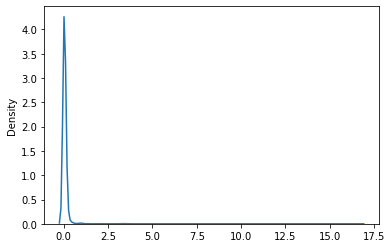

In [21]:
plot_error_count(y_true[0], y_pred[0])

In [22]:
poscar_dir = './HEA_Data/POSCARS'
poscar = os.path.join(poscar_dir, 'CoCr3_sqsbcc')
out = mp_mtl.predict(poscar)
print(out)

[tensor([[-57.4036]], device='cuda:0', grad_fn=<ScatterAddBackward0>), tensor([[-2.9470]], device='cuda:0', grad_fn=<ScatterAddBackward0>)]


In [30]:
hea_mtl = ModelPrediction(model_name='./saved_models_mtl_HEA/mtl_2_ms_mb_HEA_500_b2.pt',
                         tasks=['ms' ,'mb'], transforms=[],
                         hidden_channels=128, n_filters=64, n_interactions=3,
                         n_gaussians=50, cutoff=10, load_data_func='hea'
                         )
y_true, y_pred = hea_mtl.obtain_predictions_from_mtl()

loading (2+3+4+5) component HEA data with randomly splitting all the data into training/testing set	from D:\GitProjects\HEA_project\HEA_Data\Out_labels\Database.xlsx
The data size is 364
The number of the test size is 37
The number of the train size is 291, validation size is 36
the score of task 0 is 0.05798767879605293

the score of task 1 is 0.3860324025154114

mae in the test set is 0.22201004065573215


In [31]:
type(y_true)

list

In [32]:
y_true

[array([2.105e+00, 1.601e+00, 1.131e+00, 1.390e+00, 1.144e+00, 8.910e-01,
        1.650e-01, 8.200e-02, 1.281e+00, 4.600e-02, 1.000e-03, 2.760e-01,
        1.861e+00, 2.175e+00, 2.331e+00, 4.580e-01, 9.770e-01, 6.640e-01,
        1.640e-01, 4.640e-01, 7.830e-01, 1.710e-01, 2.520e-01, 1.227e+00,
        4.760e-01, 1.180e-01, 6.710e-01, 5.160e-01, 3.100e-02, 1.000e-03,
        4.480e-01, 5.180e-01, 5.740e-01, 1.007e+00, 1.590e+00, 2.114e+00,
        7.390e-01], dtype=float32),
 array([3.3686e+01, 2.5610e+01, 1.8093e+01, 2.2234e+01, 1.8302e+01,
        1.4261e+01, 2.6480e+00, 1.3110e+00, 2.0493e+01, 7.3200e-01,
        9.0000e-03, 4.4130e+00, 2.9782e+01, 3.4794e+01, 3.7295e+01,
        7.3320e+00, 1.5627e+01, 1.0631e+01, 2.6280e+00, 7.4230e+00,
        1.2536e+01, 2.7380e+00, 4.0360e+00, 1.9635e+01, 7.6180e+00,
        1.8950e+00, 1.0741e+01, 8.2570e+00, 4.9600e-01, 9.0000e-03,
        7.1660e+00, 8.2910e+00, 9.1770e+00, 1.6116e+01, 2.5441e+01,
        3.3819e+01, 1.1816e+01], dtype=float

In [34]:
poscar_dir = './HEA_Data/POSCARS'
poscar = os.path.join(poscar_dir, 'CoCr3_sqsbcc')
out = hea_mtl.predict(poscar)
print(out)


[tensor([[0.2068]], device='cuda:0', grad_fn=<ScatterAddBackward0>), tensor([[3.5239]], device='cuda:0', grad_fn=<ScatterAddBackward0>)]


In [40]:
from datasets.HEA_dataset import HEADataset
data_file = os.path.normpath(os.path.join('./', 'HEA_Data/Out_labels/Database.xlsx'))
total_dataset = HEADataset(poscar_dir=poscar_dir, label_name=data_file)

In [46]:
print(total_dataset.labels['CoCr3_sqsbcc'])
print(total_dataset.labels['FeCo2Mn_sqsfcc'])

{'Etot (eV/atom)': -8.79148438, 'Etot (eV)': -140.66375, 'Emix (eV/atom)': 0.07388, 'Eform (eV/atom)': 0.09872, 'Ms (emu/g)': 25.437, 'Ms (mub/atom)': 0.245, 'mb (mub/cell)': 3.914, 'rmsd (\\AA)': 0.0631, 'V0 (A3/atom)': 11.28}
{'Etot (eV/atom)': -7.756131, 'Etot (eV)': -248.19618, 'Emix (eV/atom)': 0.00174, 'Eform (eV/atom)': 0.06739, 'Ms (emu/g)': 94.21, 'Ms (mub/atom)': 0.964, 'mb (mub/cell)': 30.85, 'rmsd (\\AA)': 0.0332, 'V0 (A3/atom)': 10.98}


In [44]:
ternary_sqs = './HEA_Data/SQS_ternary_POSCAR_Files'
poscar = os.path.join(ternary_sqs, 'Co16Fe8Mn8_sqsfcc')
out = hea_mtl.predict(poscar)
print(out)

[tensor([[1.7835]], device='cuda:0', grad_fn=<ScatterAddBackward0>), tensor([[53.6836]], device='cuda:0', grad_fn=<ScatterAddBackward0>)]


In [45]:
out = hea_mtl.predict(os.path.join(poscar_dir, 'FeCo2Mn_sqsfcc'))
print(out)

[tensor([[0.9878]], device='cuda:0', grad_fn=<ScatterAddBackward0>), tensor([[29.9898]], device='cuda:0', grad_fn=<ScatterAddBackward0>)]
